In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tifffile as tif
import cv2
from PIL import Image
import os
from tensorflow.keras.utils import normalize
import matplotlib.pyplot as plt 

In [2]:
import face_recognition

In [3]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
image_dir = 'patches/images/'
mask_dir = 'patches/mask/'

In [6]:
SIZE = 256
image_dataset = []
mask_dataset = []

In [7]:
images = os.listdir(image_dir)
for i, image_name in enumerate(images):
    if(image_name.split('.')[1] == 'tiff'):
        print(image_name)
        image =  cv2.imread(image_dir+image_name,0)
        print(image)
        image = Image.fromarray(image)
        image = image.resize((SIZE,SIZE))
        image_dataset.append(np.array(image))

image_0_00.tiff
[[102 132 120 ... 155 159 162]
 [ 98 109 117 ... 141 161 156]
 [118 107 117 ... 133 163 152]
 ...
 [133 143 136 ...  96 114 129]
 [139 127 140 ... 121 120 123]
 [153 174 167 ... 116 123 123]]
image_0_01.tiff
[[148 131 118 ... 150 144 144]
 [143 112 122 ... 124 142 149]
 [133 118 113 ... 144 131 142]
 ...
 [107 121  91 ... 165 175 165]
 [107 118  99 ... 182 176 181]
 [119  98 101 ... 191 182 176]]
image_0_02.tiff
[[146 157 163 ... 192 194 176]
 [151 158 165 ... 208 186 195]
 [153 144 137 ... 192 204 200]
 ...
 [159 165 173 ... 101 106  94]
 [168 156 174 ... 100 117 102]
 [167 172 159 ...  87  85  96]]
image_0_03.tiff
[[190 185 187 ... 184 186 188]
 [202 196 194 ... 196 182 180]
 [182 186 183 ... 180 200 191]
 ...
 [ 87 122 123 ... 105  89  97]
 [115 105 107 ...  97  85 116]
 [102  99  89 ... 106 111 107]]
image_0_10.tiff
[[165 143 171 ... 133 127 120]
 [159 161 168 ... 125 136 107]
 [184 169 168 ... 125 114 115]
 ...
 [165 165 176 ... 175 165 156]
 [169 166 169 ... 167 1

[[ 93 102 101 ... 158 155 160]
 [ 92 143 108 ... 153 162 151]
 [100 111 111 ... 165 164 152]
 ...
 [190 184 177 ... 153 170 184]
 [185 190 172 ... 164 184 158]
 [177 191 172 ... 171 183 192]]
image_105_20.tiff
[[170 164 171 ... 102 103  72]
 [167 154 150 ...  79  96  84]
 [139 168 174 ...  82  78  74]
 ...
 [137 123 120 ... 135 130 116]
 [143 149 127 ... 117 119 131]
 [166 141 164 ... 134 131 144]]
image_105_21.tiff
[[ 75  88 102 ... 127 131 100]
 [ 88  98  96 ... 132 120 111]
 [104  64  99 ... 144 126 102]
 ...
 [133 119 121 ... 128 115 147]
 [146 140 119 ... 147 146 135]
 [136 130 135 ... 140 152 164]]
image_105_22.tiff
[[ 97  90  86 ... 171 187 178]
 [110  83 108 ... 173 176 152]
 [104  98  67 ... 172 181 155]
 ...
 [152 153 134 ... 146 139 145]
 [162 146 157 ... 142 139 119]
 [159 160 169 ... 133 140 121]]
image_105_23.tiff
[[166 182 165 ... 176 158 179]
 [183 169 170 ... 158 176 180]
 [159 171 175 ... 175 168 162]
 ...
 [135 141 135 ... 182 170 174]
 [120 107 114 ... 161 159 167]


[[100  91 111 ... 137 118 148]
 [119 110 102 ... 136 128 145]
 [108 108 132 ... 127 135 127]
 ...
 [181 176 158 ... 165 165 162]
 [183 173 168 ... 170 165 159]
 [181 166 197 ... 167 158 170]]
image_109_20.tiff
[[174 194 173 ... 115 111  93]
 [181 191 184 ... 138 104  69]
 [183 194 168 ... 107  92  76]
 ...
 [101 111 121 ... 110 125 127]
 [127 117 110 ... 119 117 118]
 [122 134 136 ... 119 109 104]]
image_109_21.tiff
[[ 84  95  81 ... 125 104 101]
 [ 86  81  88 ... 128 125 112]
 [ 77  79 102 ... 158 115 101]
 ...
 [128 108 116 ... 126 144 150]
 [118 117 106 ... 129 140 161]
 [106 118 110 ... 142 147 160]]
image_109_22.tiff
[[103  91  88 ... 173 178 181]
 [ 85 101  93 ... 192 179 171]
 [ 93  91  82 ... 181 169 176]
 ...
 [148 159 165 ... 146 142 140]
 [144 157 161 ... 129 111 111]
 [146 163 160 ... 105 107 111]]
image_109_23.tiff
[[174 191 174 ... 177 166 160]
 [173 175 170 ... 171 183 170]
 [183 182 174 ... 170 168 182]
 ...
 [130 103 101 ... 162 140 160]
 [107 112 110 ... 127 168 151]


image_117_03.tiff
[[104 107 143 ... 114 109 137]
 [112 110 140 ... 103 124 141]
 [121 118 151 ... 122 145 167]
 ...
 [112 107 114 ...  86 112 120]
 [110 103  99 ...  91 105 130]
 [ 91 114 106 ...  88 120 119]]
image_117_10.tiff
[[148 116 129 ... 170 174 163]
 [130 144 143 ... 168 174 145]
 [152 158 157 ... 170 177 150]
 ...
 [195 182 191 ... 166 159 151]
 [193 194 191 ... 166 162 135]
 [182 184 190 ... 160 149 144]]
image_117_11.tiff
[[159 139 145 ... 178 167 169]
 [164 129 130 ... 178 181 174]
 [165 148 163 ... 180 173 153]
 ...
 [132 141 141 ...  94 118 118]
 [133 137 128 ... 105 105 120]
 [141 148 131 ...  99 132 152]]
image_117_12.tiff
[[175 172 158 ... 103 115 114]
 [182 167 153 ... 128  81 131]
 [166 178 139 ... 107 103 106]
 ...
 [135 116  87 ... 173 160 175]
 [132 113 116 ... 153 171 159]
 [136 124  94 ... 169 175 178]]
image_117_13.tiff
[[112 116 108 ...  88 122 143]
 [106 132 110 ... 117 146 144]
 [ 96 111 110 ... 139 135 153]
 ...
 [164 194 184 ... 103 110 115]
 [165 189 185

image_121_02.tiff
[[189 183 179 ... 116  89 123]
 [187 197 189 ... 114  88  97]
 [185 189 198 ... 100  96 115]
 ...
 [156 177 178 ... 114 105 126]
 [170 163 157 ... 104  98 109]
 [181 172 172 ... 115 106 123]]
image_121_03.tiff
[[108 103 146 ... 101  92 120]
 [112 136 145 ... 117 131 173]
 [102 135 154 ... 126 142 165]
 ...
 [122 108 107 ...  83  94  90]
 [100 123  98 ...  77  87  84]
 [100 106 119 ...  97  90  84]]
image_121_10.tiff
[[154 163 163 ... 153 140 166]
 [164 153 158 ... 146 155 151]
 [158 168 149 ... 155 148 142]
 ...
 [186 191 177 ... 160 145 177]
 [190 179 191 ... 146 156 166]
 [197 193 190 ... 149 132 165]]
image_121_11.tiff
[[147 156 158 ... 191 171 183]
 [160 161 146 ... 198 194 167]
 [153 154 161 ... 190 180 165]
 ...
 [166 180 165 ... 114 138 142]
 [176 170 169 ... 109 128 132]
 [187 178 176 ... 110 123 154]]
image_121_12.tiff
[[158 168 173 ... 102 111 121]
 [151 160 162 ...  98  85 110]
 [161 170 173 ... 108 118 101]
 ...
 [135 121  94 ... 145 132 138]
 [141 124  92

[[165 176 154 ... 152 181 176]
 [172 156 158 ... 184 184 185]
 [158 162 165 ... 172 179 176]
 ...
 [146 135 138 ... 143 132 141]
 [144 137 136 ... 162 149 151]
 [148 141 141 ... 159 149 165]]
image_12_03.tiff
[[198 171 187 ... 171 171 167]
 [172 178 184 ... 171 161 165]
 [187 162 172 ... 162 172 173]
 ...
 [137 145 173 ...  86 103 100]
 [159 158 180 ... 116  98 113]
 [159 173 163 ...  95 106 104]]
image_12_10.tiff
[[169 176 155 ... 123  92 113]
 [162 160 157 ... 107 104  87]
 [122 134 140 ...  88  96  88]
 ...
 [180 178 195 ... 171 156 154]
 [180 154 164 ... 167 139 124]
 [177 157 171 ... 126 145 135]]
image_12_11.tiff
[[ 83  92  98 ... 119 137 135]
 [ 91 102  93 ... 117 136 141]
 [ 91  86 117 ... 136 129 126]
 ...
 [137 132 146 ... 172 186 166]
 [130 117 129 ... 172 181 187]
 [120 114 143 ... 176 179 178]]
image_12_12.tiff
[[141 115 114 ... 133 147 158]
 [128 129 104 ... 172 142 156]
 [145 137 136 ... 132 149 130]
 ...
 [168 144 137 ...  90  92 100]
 [170 173 161 ... 118  90  94]
 [17

[[116 110 112 ...  99  99  98]
 [109  90  95 ... 123 119 108]
 [ 85  93  85 ... 108 108 112]
 ...
 [107  99 104 ... 123 105 115]
 [ 96 113 117 ... 144 121 124]
 [ 97 106 106 ... 121 129 118]]
image_133_00.tiff
[[160 162 143 ... 134 126 100]
 [185 163 175 ... 111  97 129]
 [164 161 162 ... 109  97 116]
 ...
 [157 172 172 ... 151 160 171]
 [159 158 161 ... 172 195 170]
 [162 174 157 ... 173 183 175]]
image_133_01.tiff
[[129 150 173 ... 151 153 167]
 [137 149 171 ... 159 153 162]
 [135 158 159 ... 156 153 146]
 ...
 [171 176 185 ... 179 197 169]
 [191 182 168 ... 172 174 184]
 [173 168 187 ... 168 171 183]]
image_133_02.tiff
[[158 181 179 ... 124 131 114]
 [172 166 177 ... 121 109 111]
 [165 163 207 ...  97 105 114]
 ...
 [197 191 180 ... 118 113 145]
 [183 188 188 ... 122 129 127]
 [190 201 178 ... 125 141 116]]
image_133_03.tiff
[[119 125 111 ... 132 119 131]
 [100 109  99 ... 122 144 145]
 [112 106  99 ... 142 154 141]
 ...
 [125 124 130 ... 104 103  97]
 [144 116 110 ... 111 106  95]


[[105 108 100 ... 113 134 113]
 [120 104  96 ... 157 129 133]
 [108 110 102 ... 144 149 129]
 ...
 [103  91  94 ...  90  88 113]
 [111 103 103 ... 103  97 100]
 [101 100 112 ... 106 112 106]]
image_142_10.tiff
[[177 176 167 ... 159 164 186]
 [173 144 162 ... 161 160 182]
 [144 138 153 ... 144 143 150]
 ...
 [182 167 174 ... 192 173 182]
 [171 182 191 ... 183 171 182]
 [181 167 186 ... 179 187 188]]
image_142_11.tiff
[[202 168 165 ... 123 133 131]
 [172 176 179 ... 134 116 121]
 [175 187 163 ... 118 122 137]
 ...
 [170 173 169 ... 122 111  95]
 [169 178 176 ... 112 100  88]
 [182 185 185 ...  96 108  67]]
image_142_12.tiff
[[135 138 139 ...  96 112 109]
 [124 128 123 ... 108 104 104]
 [124 122 136 ... 109 121 128]
 ...
 [ 79  73 115 ... 161 158 160]
 [ 94  86  85 ... 130 120 142]
 [100  88  89 ... 142 126 101]]
image_142_13.tiff
[[103 112 137 ... 112 122 111]
 [128 125 133 ... 116 122 128]
 [122 141 145 ... 116 113 113]
 ...
 [148 117 120 ... 135 137 149]
 [121 110  91 ... 126 145 141]


[[160 151 152 ... 114 118 122]
 [164 147 156 ... 147 155 159]
 [164 171 160 ... 150 156 151]
 ...
 [125 119 139 ... 137 148 153]
 [102 115 130 ... 149 162 161]
 [ 86  96 119 ... 147 154 169]]
image_147_03.tiff
[[136 147 157 ... 154 160 151]
 [141 157 140 ... 144 132 148]
 [141 125 112 ... 133 134 134]
 ...
 [163 141 143 ... 106 117  93]
 [138 150 135 ... 123  98  93]
 [143 133 114 ... 110 124 121]]
image_147_10.tiff
[[180 173 160 ... 169 170 169]
 [192 173 176 ... 148 172 159]
 [195 180 179 ... 160 145 147]
 ...
 [144 144 132 ... 154 164 164]
 [140 145 152 ... 176 181 170]
 [150 140 147 ... 159 163 174]]
image_147_11.tiff
[[157 163 152 ... 118 114 111]
 [160 153 155 ... 131 101  95]
 [145 147 178 ... 106 114  93]
 ...
 [167 181 190 ...  95  99  96]
 [176 191 197 ... 100  98  82]
 [172 177 166 ...  89  86 113]]
image_147_12.tiff
[[107  98 125 ... 177 147 150]
 [ 87 117 115 ... 150 153 138]
 [ 75  90 102 ... 150 127 119]
 ...
 [ 93 100 105 ... 122 128 116]
 [ 95 101 102 ... 113 119 105]


[[132 184 152 ...  94 108  97]
 [171 139 161 ...  94  80 120]
 [156 165 184 ... 154  84 136]
 ...
 [160 146 145 ... 110 165 149]
 [203 176 163 ... 133 186 173]
 [171 140 137 ... 185 202 188]]
image_156_01.tiff
[[127 116 102 ... 183 188 176]
 [116 107 121 ... 195 203 172]
 [110 102 132 ... 196 189 152]
 ...
 [196 200 174 ... 128 173 172]
 [195 179 177 ... 184 198 161]
 [202 198 191 ... 177 207 166]]
image_156_02.tiff
[[189 137 184 ... 150 133 118]
 [148 163 184 ... 170 140 138]
 [139 154 185 ... 179 129 129]
 ...
 [181 153 172 ... 136 183 139]
 [175 222 157 ... 186 119 154]
 [179 215 201 ... 185 190 166]]
image_156_03.tiff
[[ 99  77 123 ... 125 112 138]
 [113 111  81 ... 154  98 100]
 [108 131 107 ... 114 132 176]
 ...
 [118 171 165 ... 101  75 170]
 [173 140 191 ... 109 134 135]
 [169 164 203 ... 122 130 139]]
image_156_10.tiff
[[141 138 137 ... 177 193 185]
 [145 141 154 ... 158 194 202]
 [148 176 143 ... 151 180 198]
 ...
 [185 193 201 ... 162 178 165]
 [120 176 179 ... 139 170 158]


[[158 166 147 ... 102 123 133]
 [194 180 178 ... 106 116  88]
 [189 164 187 ... 102  90  99]
 ...
 [172 158 159 ... 182 172 162]
 [170 166 163 ... 152 163 174]
 [169 169 172 ... 157 161 174]]
image_160_01.tiff
[[115 116 110 ... 186 181 169]
 [100 104 105 ... 167 185 182]
 [100 106 122 ... 187 156 168]
 ...
 [171 164 170 ... 186 166 182]
 [172 173 152 ... 194 186 189]
 [160 170 159 ... 181 192 194]]
image_160_02.tiff
[[183 162 173 ... 107 135 153]
 [172 163 163 ... 113 159 153]
 [181 165 161 ... 119 147 162]
 ...
 [164 183 166 ... 175 184 194]
 [185 170 161 ... 183 184 187]
 [188 182 173 ... 171 189 185]]
image_160_03.tiff
[[160 180 168 ... 150 169 174]
 [186 173 158 ... 164 165 156]
 [159 139 106 ... 169 176 160]
 ...
 [185 174 181 ... 117 123 113]
 [186 178 182 ... 128 132 134]
 [188 199 206 ... 128 113 137]]
image_160_10.tiff
[[169 165 168 ... 166 168 188]
 [162 164 159 ... 171 169 194]
 [142 154 144 ... 173 192 162]
 ...
 [184 172 188 ... 169 139 141]
 [188 184 183 ... 168 147 140]


image_1_20.tiff
[[177 184 159 ... 120 136 128]
 [186 178 187 ... 124 130 130]
 [177 178 187 ... 122 103 112]
 ...
 [113 133 126 ... 150 137 146]
 [122 127 136 ... 158 166 159]
 [144 135 118 ... 158 167 146]]
image_1_21.tiff
[[137 113 118 ... 181 181 167]
 [112 117 134 ... 199 187 172]
 [115  95 138 ... 183 179 188]
 ...
 [143 138 155 ... 139 114 116]
 [157 173 164 ... 111  97 115]
 [152 156 167 ... 122 113 109]]
image_1_22.tiff
[[169 166 170 ...  92 113  84]
 [169 183 172 ...  88 105 119]
 [181 178 172 ... 117 118 143]
 ...
 [109 120 122 ... 182 176 172]
 [108  96  92 ... 179 174 157]
 [100  86  81 ... 154 166 167]]
image_1_23.tiff
[[126 138 121 ... 171 175 173]
 [127 153 134 ... 170 164 160]
 [148 151 136 ... 180 164 169]
 ...
 [140 117 100 ... 163 148 162]
 [149 127  91 ... 126 158 170]
 [124 114 111 ... 137 149 162]]
image_20_00.tiff
[[110 103 114 ... 122 134 146]
 [101 115 109 ... 135 151 147]
 [104  97  87 ... 142 142 152]
 ...
 [161 155 159 ... 100  99  86]
 [153 164 162 ...  92 

[[132 133 122 ... 149 164 176]
 [115 130 125 ... 152 147 173]
 [118 110 127 ... 156 141 151]
 ...
 [140 136 103 ...  95 109  86]
 [165 144 122 ... 110  74 101]
 [164 148 130 ...  71  91  87]]
image_24_22.tiff
[[166 172 163 ... 159 172 157]
 [157 154 165 ... 153 150 155]
 [172 149 143 ... 133 137 143]
 ...
 [ 92  97  84 ... 172 158 146]
 [ 99 104  90 ... 148 153 150]
 [ 88  73  90 ... 164 118 145]]
image_24_23.tiff
[[149 146 123 ... 174 178 161]
 [153 114 107 ... 152 188 170]
 [129 112 100 ... 187 161 187]
 ...
 [144 138 146 ...  96 105  94]
 [141 126 125 ... 109 111 114]
 [124 134 125 ... 105 107 112]]
image_25_00.tiff
[[ 87  93  91 ... 110 132 149]
 [ 82  79  92 ...  96 142 150]
 [100  94 104 ... 123 154 154]
 ...
 [128 119 126 ...  97 109 120]
 [126 134 117 ... 111 117 126]
 [116 109 112 ... 137 130 138]]
image_25_01.tiff
[[151 158 149 ... 144 146 144]
 [172 166 147 ... 138 136 167]
 [162 175 169 ... 140 147 141]
 ...
 [111 127 138 ... 175 188 169]
 [118 138 137 ... 183 171 181]
 [13

image_33_12.tiff
[[176 146 154 ... 100 100  94]
 [176 161 159 ...  90  88  80]
 [157 160 176 ...  77  83  78]
 ...
 [173 160 147 ...  98  99  79]
 [178 164 175 ...  89  82  87]
 [168 150 156 ...  85  99 104]]
image_33_13.tiff
[[ 88 125 108 ... 173 174 161]
 [ 86  98  76 ... 163 187 178]
 [ 97  92  92 ... 161 165 164]
 ...
 [ 79  93 105 ... 176 180 169]
 [ 96 103 100 ... 156 170 170]
 [101 117 106 ... 158 167 165]]
image_33_20.tiff
[[194 175 176 ... 100  88 100]
 [176 188 163 ... 102  93 102]
 [177 165 157 ... 102 103  97]
 ...
 [131 111 137 ... 166 154 155]
 [126  89 132 ... 156 152 155]
 [105 119  94 ... 171 141 138]]
image_33_21.tiff
[[131 112 130 ... 135 158 158]
 [115 109 113 ... 122 134 150]
 [114 109 112 ... 116 128 143]
 ...
 [151 147 146 ... 110 130 140]
 [157 140 155 ... 114 120 116]
 [143 131 120 ... 117 105 129]]
image_33_22.tiff
[[145 141 154 ...  81 101 112]
 [148 151 133 ...  94  97 114]
 [134 156 124 ... 114 117 137]
 ...
 [155 156 135 ... 145 159 145]
 [140 142 136 ... 

[[195 199 197 ... 124 128 127]
 [188 187 185 ... 128 140 124]
 [189 194 196 ... 137 133  97]
 ...
 [ 70  88  97 ... 159 154 125]
 [ 82  95 105 ... 159 132 124]
 [ 77  87 103 ... 159 131 123]]
image_38_10.tiff
[[146 146 123 ... 126 116  99]
 [155 146 143 ... 129 113  91]
 [140 144 149 ... 127 109  78]
 ...
 [159 172 154 ... 131 138 124]
 [182 175 177 ... 124 121 136]
 [165 156 179 ... 117 116 131]]
image_38_11.tiff
[[114 111 147 ... 105 141 174]
 [110 110 124 ... 119 156 173]
 [ 97 108 136 ... 125 147 152]
 ...
 [131 129 123 ... 168 139 164]
 [135 134 132 ... 128 146 147]
 [119 116 125 ... 146 156 155]]
image_38_12.tiff
[[174 186 179 ...  77  84  61]
 [175 170 180 ...  77  88  70]
 [187 178 176 ...  65  80 100]
 ...
 [152 132 161 ... 104 115 119]
 [138 153 154 ... 129 117 136]
 [148 146 155 ... 134 150 149]]
image_38_13.tiff
[[ 89  95 109 ... 149 124 102]
 [ 84  91 105 ... 143 135 117]
 [ 91  73  99 ... 147 116  90]
 ...
 [118 129 131 ... 180 181 176]
 [162 156 127 ... 187 174 169]
 [15

image_47_13.tiff
[[147 151 118 ...  96  97  96]
 [147 149 133 ...  99 102 101]
 [141 146 121 ...  83  92  83]
 ...
 [106 105 117 ... 183 195 197]
 [104 125 137 ... 196 177 176]
 [102 122 132 ... 181 186 177]]
image_47_20.tiff
[[180 182 193 ... 134 142 154]
 [177 163 186 ... 171 146 164]
 [182 193 185 ... 142 155 157]
 ...
 [181 163 181 ... 161 120 129]
 [169 173 165 ... 142 119 136]
 [170 162 165 ... 139 143 136]]
image_47_21.tiff
[[165 145 130 ... 175 181 163]
 [165 159 141 ... 165 175 185]
 [171 156 155 ... 167 175 159]
 ...
 [118 120 115 ...  88  95 116]
 [142 139 138 ...  95 113 114]
 [133 147 129 ... 116  93  89]]
image_47_22.tiff
[[168 166 180 ...  98  95  92]
 [180 178 177 ... 110 117 105]
 [168 183 190 ... 112 120 128]
 ...
 [123 119 140 ... 184 159 182]
 [118 143 122 ... 180 174 171]
 [112 117 124 ... 161 166 163]]
image_47_23.tiff
[[111 143 135 ... 193 184 190]
 [113 139 167 ... 194 187 192]
 [140 131 156 ... 178 193 191]
 ...
 [182 185 166 ...  98  96 101]
 [180 176 158 ... 

[[191 182 187 ... 144 125 142]
 [185 188 192 ... 143 152 151]
 [188 180 178 ... 138 152 157]
 ...
 [169 172 166 ... 115 118 115]
 [176 188 176 ... 125 104 112]
 [180 165 171 ... 109 100 101]]
image_51_21.tiff
[[151 156 152 ... 176 186 169]
 [149 162 176 ... 168 168 171]
 [169 155 165 ... 185 153 168]
 ...
 [117 114 102 ... 147 103 105]
 [110 109  94 ... 119 108  92]
 [ 90 105  95 ... 121  95 109]]
image_51_22.tiff
[[166 177 171 ... 119 105 124]
 [152 175 169 ... 109 119 113]
 [187 190 172 ... 120 132 117]
 ...
 [124 108 113 ... 167 173 176]
 [ 80 113 124 ... 172 160 181]
 [ 87 111 112 ... 174 165 189]]
image_51_23.tiff
[[124 119 107 ... 186 187 180]
 [115 117 113 ... 183 174 186]
 [110 120 106 ... 184 189 181]
 ...
 [198 186 168 ... 105 119  97]
 [175 194 188 ... 109 106 115]
 [175 198 176 ... 113  99  93]]
image_52_00.tiff
[[119 124 105 ... 143 136 142]
 [121 109 125 ... 110  96 109]
 [115 112 115 ... 108 108 107]
 ...
 [163 172 160 ... 130 162 143]
 [177 165 156 ... 140 154 158]
 [18

[[169 158 154 ... 125 126 113]
 [154 156 164 ... 127  97 121]
 [149 141 164 ... 134 104 101]
 ...
 [ 92 118 143 ... 169 179 189]
 [ 76 121 125 ... 188 176 194]
 [103 110 116 ... 174 184 181]]
image_60_23.tiff
[[124 141 135 ... 139 142 138]
 [104 139 122 ... 145 156 173]
 [117 112 124 ... 166 171 164]
 ...
 [157 172 151 ... 110  94 107]
 [159 182 168 ... 113  96 122]
 [165 169 154 ... 121 112 106]]
image_61_00.tiff
[[104  97 109 ... 115  93 104]
 [115 101 107 ... 125 109 131]
 [ 99 123 135 ... 120 141 149]
 ...
 [178 171 179 ... 113 118 136]
 [172 159 150 ... 110 129 114]
 [170 173 170 ... 125 128 117]]
image_61_01.tiff
[[111 126 122 ... 116 133 135]
 [154 155 163 ... 135 153 166]
 [150 167 179 ... 150 143 152]
 ...
 [130 121 111 ... 136 136 164]
 [129 110 114 ... 126 137 172]
 [127 114 116 ... 117 144 165]]
image_61_02.tiff
[[124 117 121 ... 187 192 199]
 [147 119 124 ... 184 186 189]
 [138 143 115 ... 198 197 201]
 ...
 [172 141 163 ... 100 100 116]
 [180 148 180 ... 129 131 124]
 [17

[[ 98 128 132 ... 138 136 117]
 [103 115 124 ... 143 111 113]
 [ 92 112 134 ... 135 102 121]
 ...
 [119 122 154 ... 159 161 128]
 [103 109 145 ... 159 149 148]
 [104 126 105 ... 147 143 147]]
image_65_23.tiff
[[112 129 130 ... 130 128 115]
 [116 118 152 ... 134 127 121]
 [102 121 122 ... 149 145 107]
 ...
 [140 132 129 ... 123 103  81]
 [140 119 137 ... 132 136  85]
 [135 135 122 ... 119 104  96]]
image_66_00.tiff
[[124 131 114 ...  99 106 136]
 [126 131 125 ... 110 123 127]
 [ 93 108 120 ... 148 156 147]
 ...
 [192 169 188 ... 117 126 143]
 [187 187 169 ... 118 129 122]
 [176 175 185 ... 137 136 134]]
image_66_01.tiff
[[117 139 158 ... 158 174 167]
 [144 168 155 ... 172 137 151]
 [173 154 150 ... 181 156 146]
 ...
 [111 117 112 ... 169 190 173]
 [118 117 103 ... 158 186 179]
 [115 120 105 ... 154 171 173]]
image_66_02.tiff
[[156 163 149 ... 194 213 187]
 [147 131 134 ... 192 210 190]
 [157 117 138 ... 199 200 195]
 ...
 [177 186 174 ... 163 179 170]
 [175 185 195 ... 164 171 181]
 [17

[[184 182 176 ... 124 127 143]
 [192 177 171 ... 133 127 133]
 [186 173 193 ... 121 136 118]
 ...
 [111 133 124 ... 142 141 139]
 [133 127 140 ... 147 151 139]
 [120 107 118 ... 144 143 127]]
image_74_21.tiff
[[111 105  86 ... 164 156 141]
 [ 96 110  87 ... 162 152 154]
 [107  94  91 ... 163 142 137]
 ...
 [156 162 153 ... 130 149 136]
 [136 148 140 ... 114 113 150]
 [135 139 124 ... 124 119 122]]
image_74_22.tiff
[[160 135 170 ... 188 172 168]
 [150 146 138 ... 171 178 173]
 [161 136 167 ... 181 167 157]
 ...
 [174 163 167 ... 177 183 185]
 [148 170 165 ... 177 183 159]
 [151 172 159 ... 178 167 178]]
image_74_23.tiff
[[160 176 134 ... 157 165 177]
 [171 141 143 ... 167 145 161]
 [138 137 115 ... 158 169 158]
 ...
 [170 188 171 ...  97 103 114]
 [176 171 195 ...  96  99  80]
 [185 180 190 ...  98 112  77]]
image_75_00.tiff
[[116 116 124 ... 143 125 129]
 [132 141 158 ... 105 112 110]
 [136 132 148 ... 133 142 106]
 ...
 [200 203 188 ... 122 101 122]
 [197 182 177 ... 132 124 103]
 [19

image_79_23.tiff
[[179 168 168 ... 173 180 183]
 [169 168 160 ... 161 180 180]
 [163 170 164 ... 192 174 188]
 ...
 [188 175 180 ... 111 109 101]
 [180 192 191 ...  98  99  88]
 [198 175 184 ...  87  83  78]]
image_7_00.tiff
[[155 152 148 ... 126 140 136]
 [147 174 153 ... 153 132 134]
 [152 150 153 ... 126 112  98]
 ...
 [158 148 140 ... 104 114 103]
 [133 138 150 ... 104 110 124]
 [160 149 147 ...  97 111 105]]
image_7_01.tiff
[[167 148 152 ... 103 101 107]
 [110 122 107 ... 100  91  96]
 [105 104  84 ... 111 131 113]
 ...
 [127 126 114 ...  84 107 110]
 [112 109 100 ... 112 114  97]
 [105 127  79 ... 112 115 105]]
image_7_02.tiff
[[118  99 109 ... 152 154 169]
 [116 103 100 ... 142 150 148]
 [106 112 109 ... 155 152 160]
 ...
 [105  93 100 ... 122 115 137]
 [ 90 118  95 ... 117 130 135]
 [ 96 104 103 ... 149 133 148]]
image_7_03.tiff
[[154 154 144 ... 181 168 195]
 [149 154 154 ... 180 163 185]
 [143 160 153 ... 164 158 187]
 ...
 [127 125 146 ...  73  94  89]
 [116 113 139 ...  88 

[[104  85 116 ... 105 110 103]
 [121  90  89 ... 103 123 118]
 [113  95 121 ...  96 113 129]
 ...
 [184 171 171 ... 169 177 159]
 [182 165 163 ... 163 163 154]
 [193 171 147 ... 146 164 157]]
image_88_13.tiff
[[126 133 115 ...  95  65  75]
 [133 126 127 ... 107  68  91]
 [135 131 136 ... 101 119  81]
 ...
 [165 186 175 ... 171 184 192]
 [172 167 178 ... 197 183 172]
 [160 187 167 ... 179 178 178]]
image_88_20.tiff
[[135 134 130 ...  87  92  86]
 [117 129 120 ...  91  95 130]
 [141 143 131 ... 107 115 128]
 ...
 [141 139 154 ... 154 171 148]
 [169 151 143 ... 146 147 146]
 [131 153 144 ... 137 125 137]]
image_88_21.tiff
[[116 141 145 ... 182 177 187]
 [127 141 141 ... 154 171 166]
 [135 167 160 ... 173 185 174]
 ...
 [135 140 144 ... 166 165 170]
 [141 136 131 ... 188 171 153]
 [110 128 118 ... 178 158 173]]
image_88_22.tiff
[[167 153 156 ... 162 157 166]
 [175 163 168 ... 166 162 156]
 [169 170 160 ... 159 157 162]
 ...
 [155 149 148 ... 139 162 147]
 [149 156 158 ... 147 160 144]
 [16

[[135 119 136 ... 189 180 195]
 [110 119 107 ... 177 189 190]
 [125 103 130 ... 191 190 183]
 ...
 [114 141 151 ... 106 133 138]
 [128 130 153 ... 117 124 111]
 [107 137 141 ... 131 108 136]]
image_92_03.tiff
[[187 194 185 ... 143 142 126]
 [195 184 189 ... 122 114 133]
 [189 190 189 ... 118 112  99]
 ...
 [120 139 136 ... 132 103  99]
 [131 126  99 ... 130 108  95]
 [124 132 120 ...  97  91  93]]
image_92_10.tiff
[[155 171 173 ... 133 142 151]
 [164 170 179 ... 145 153 171]
 [187 187 155 ... 153 143 148]
 ...
 [169 161 164 ... 108  85  94]
 [161 166 173 ...  95  86 101]
 [155 155 146 ... 105 100  74]]
image_92_11.tiff
[[163 130 156 ... 100 100  86]
 [164 154 168 ... 137 106  99]
 [162 148 160 ... 128 110 113]
 ...
 [ 96  85 133 ... 129 141 149]
 [ 82 103 116 ... 121 141 128]
 [ 99 120 133 ... 121 123 143]]
image_92_12.tiff
[[102 109 134 ... 111 122 126]
 [107 114 126 ... 118 129 125]
 [108 104 116 ... 143 131 129]
 ...
 [132 145 156 ... 164 154 171]
 [130 131 142 ... 150 158 172]
 [12

In [8]:
image_dataset

[array([[102, 132, 120, ..., 155, 159, 162],
        [ 98, 109, 117, ..., 141, 161, 156],
        [118, 107, 117, ..., 133, 163, 152],
        ...,
        [133, 143, 136, ...,  96, 114, 129],
        [139, 127, 140, ..., 121, 120, 123],
        [153, 174, 167, ..., 116, 123, 123]], dtype=uint8),
 array([[148, 131, 118, ..., 150, 144, 144],
        [143, 112, 122, ..., 124, 142, 149],
        [133, 118, 113, ..., 144, 131, 142],
        ...,
        [107, 121,  91, ..., 165, 175, 165],
        [107, 118,  99, ..., 182, 176, 181],
        [119,  98, 101, ..., 191, 182, 176]], dtype=uint8),
 array([[146, 157, 163, ..., 192, 194, 176],
        [151, 158, 165, ..., 208, 186, 195],
        [153, 144, 137, ..., 192, 204, 200],
        ...,
        [159, 165, 173, ..., 101, 106,  94],
        [168, 156, 174, ..., 100, 117, 102],
        [167, 172, 159, ...,  87,  85,  96]], dtype=uint8),
 array([[190, 185, 187, ..., 184, 186, 188],
        [202, 196, 194, ..., 196, 182, 180],
        [182, 18

In [9]:
masks = os.listdir(mask_dir)
for i ,mask_name in enumerate(masks):
    if(mask_name.split('.')[1]=='tiff'):
        mask = cv2.imread(mask_dir+mask_name,0)
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE,SIZE))
        mask_dataset.append(np.array(mask))

In [10]:
mask_dataset

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0

In [11]:
image_dataset = np.expand_dims(normalize(np.array(image_dataset),axis = 1),3)

In [12]:
mask_dataset = np.expand_dims(np.array(mask_dataset),3)/255

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train,X_test ,y_train,y_test = train_test_split(image_dataset,mask_dataset,test_size=0.10,random_state=42)

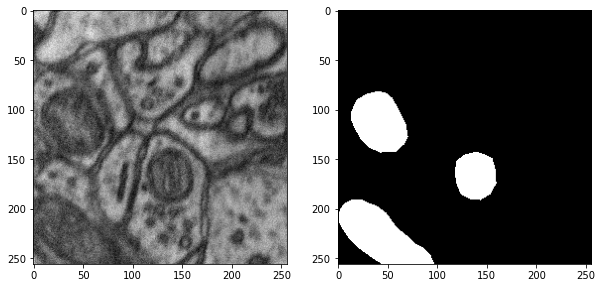

In [15]:
import random
import numpy as np
image_number = random.randint(0,len(X_train))
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number],(256,256)),cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number],(256,256)),cmap='gray')
plt.show()

In [16]:
X_train.shape

(1782, 256, 256, 1)

In [17]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]


In [18]:
from Simple_Unet import simple_unet_model

In [19]:
def get_model():
    return simple_unet_model(IMG_HEIGHT=IMG_HEIGHT,IMG_WIDTH=IMG_WIDTH,IMG_CHANNELS=IMG_CHANNELS)

In [20]:
model = get_model()

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [22]:
l1 = sm.losses.DiceLoss()

In [23]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [24]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size = 16,epochs = 10,shuffle=False)

Epoch 1/10
112/112 [==============================] - 26s 173ms/step - loss: 0.2017 - accuracy: 0.9415 - val_loss: 0.2643 - val_accuracy: 0.9452
Epoch 2/10
112/112 [==============================] - 18s 158ms/step - loss: 0.0998 - accuracy: 0.9483 - val_loss: 0.0935 - val_accuracy: 0.9745
Epoch 3/10
112/112 [==============================] - 17s 153ms/step - loss: 0.0524 - accuracy: 0.9809 - val_loss: 0.0866 - val_accuracy: 0.9622
Epoch 4/10
112/112 [==============================] - 17s 152ms/step - loss: 0.0300 - accuracy: 0.9883 - val_loss: 0.0367 - val_accuracy: 0.9871
Epoch 5/10
112/112 [==============================] - 17s 151ms/step - loss: 0.0245 - accuracy: 0.9905 - val_loss: 0.0305 - val_accuracy: 0.9896
Epoch 6/10
112/112 [==============================] - 17s 151ms/step - loss: 0.0172 - accuracy: 0.9931 - val_loss: 0.0201 - val_accuracy: 0.9923
Epoch 7/10
112/112 [==============================] - 17s 151ms/step - loss: 0.0169 - accuracy: 0.9933 - val_loss: 0.0232 - val_ac

In [25]:
acc = model.evaluate(X_test,y_test)

7/7 [==============================] - 2s 79ms/step - loss: 0.0167 - accuracy: 0.9936


In [26]:
y_pred = model.predict(X_test)
y_pred_threshold = y_pred>0.2
y_pred

array([[[[1.04632407e-01],
         [5.62601015e-02],
         [4.46295552e-02],
         ...,
         [6.77183503e-03],
         [9.59911104e-03],
         [7.90824369e-02]],

        [[6.19571544e-02],
         [2.27989648e-02],
         [1.77946277e-02],
         ...,
         [5.45737043e-04],
         [1.15125743e-03],
         [4.85948287e-03]],

        [[3.15764621e-02],
         [1.25872893e-02],
         [1.53142530e-02],
         ...,
         [3.18433944e-04],
         [8.71162221e-04],
         [3.06824804e-03]],

        ...,

        [[3.19730002e-03],
         [2.06405733e-04],
         [1.62717944e-04],
         ...,
         [2.50539044e-03],
         [3.94622795e-03],
         [5.47007844e-03]],

        [[5.01963263e-03],
         [9.24548076e-04],
         [1.98600741e-04],
         ...,
         [4.56361799e-03],
         [4.90051275e-03],
         [1.23473424e-02]],

        [[2.12428756e-02],
         [3.45250592e-03],
         [1.75996101e-03],
         ...,
 

In [27]:
y_pred_threshold

array([[[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        ...,

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]],


       [[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [Fa

In [28]:
intersection = np.logical_and(y_test,y_pred_threshold)
union = np.logical_or(y_test,y_pred_threshold)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

0.8392568398097935


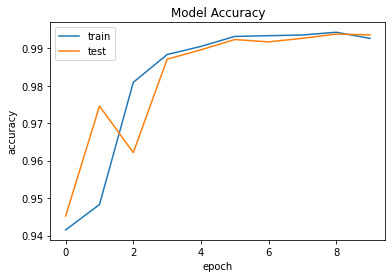

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [30]:
#model.save('Diceloss_10 epochs.h5')

In [1]:
test_img_nos = random.randint(0,len(X_test))
test_img = X_test[test_img_nos]
ground_truth = y_test[test_img_nos]
test_img_norm = test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img_norm,0)
prediction = (model.predict(test_img_input)[0,:,:,0]>0.2).astype(np.uint8)

NameError: name 'random' is not defined

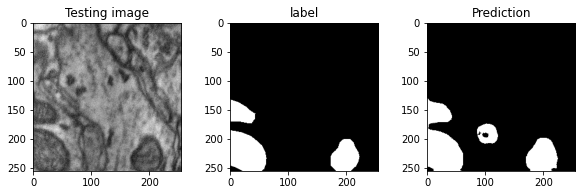

In [32]:
plt.figure(figsize=(10,6))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(test_img[:,:,0],cmap='gray')
plt.subplot(232)
plt.title('label')
plt.imshow(ground_truth[:,:,0],cmap ='gray')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction,cmap='gray')
plt.show()